# **COMP2611**
## *Artificial Intelligence*
### *Assignment 1: Search Algorithms*
### *Mario Manini - sc23mm2@leeds.ac.uk*
### *Jonghyun Kim - sc23j3k@leeds.ac.uk*

Declaration A.
We confirm that we have worked as pair on this project and both of us have made significant
contributions to both parts of the assignment.
We are aware that both members of the pair will receive the same grade.
We confirm that only one submission submission has been made via Gradescope.
The submitter confirms that they have agreed the final submitted version of this report with the
other member of the pair.
The submitter confirms that, after submitting the report to Gradescope, they have
added the other member of the pair to the group associated with the submission.

#### *A. Sliding Blocks Puzzle Search Investigation*


    




In [2]:
#!echo Installing bbSearch module from web ...
#!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
#!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py

from bbmodcache.bbSearch import SearchProblem, search

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown","black","lime"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())

from copy import deepcopy
class SlidingBlocksPuzzle( SearchProblem ):

    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18767  100 18767    0     0   305k      0 --:--:-- --:--:-- --:--:--  305k


#### *A1(a) Puzzle Test Cases*
For our test cases, we have chosen three different cases to model. 

Case 1:\
-A 3x3 grid, 4 small blocks.\
-This grid will test the different algorithm's efficiency when solving simpler problems.

![Alt text](path/to/image.png)





Case 2:\
-A grid resembling a maze, seemingly intuitive.\
-We tried a larger grid to simulate a path finding problem.\



Case 3:\
-A classic sliding block puzzle of higher difficulty.\
-Consisting of blocks with varying shape.\
-Requiring more moves, even with an optimal solution.\




Solve the following sliding blocks problem.
Get from this initial state:


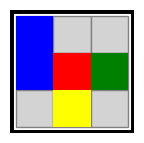

To a state incorporating the following block position(s):


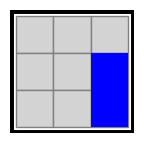

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 10000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 8
Goal state is:


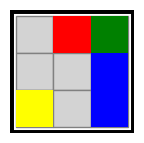

The action path to the solution is:
('red', 'up')
('red', 'right')
('blue', 'right')
('yellow', 'left')
('blue', 'down')
('red', 'left')
('green', 'up')
('blue', 'right')

The state/action path to the solution is:


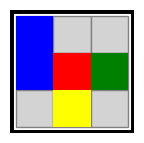

('red', 'up')


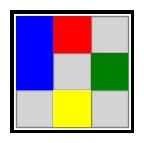

('red', 'right')


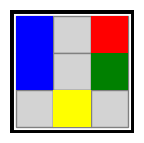

('blue', 'right')


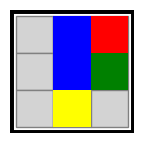

('yellow', 'left')


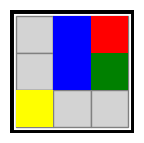

('blue', 'down')


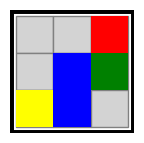

('red', 'left')


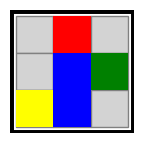

('green', 'up')


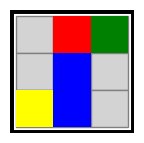

('blue', 'right')


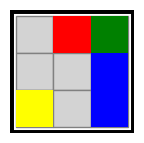


SEARCH SPACE STATS:
Total nodes generated          =     2838  (includes start)
Nodes discarded by loop_check  =     2149  (689 distinct states added to queue)
Nodes tested (by goal_test)    =      545  (544 expanded + 1 goal)
Nodes left in queue            =      144

Time taken = 0.6727 seconds



In [ ]:
#Easy Puzzle

easy = [[2,0,0],
         [2,1,3],
         [0,4,0]]

easy_goal = [[0,0,0],
            [0,0,2],
            [0,0,2]]

easy_puzzle =  SlidingBlocksPuzzle(easy, easy_goal )

test = SlidingBlocksPuzzle(easy, easy_goal )

search

hard = [[0,0,4,0,0],
        [3,3,4,4,4],
        [1,2,7,7,5],
        [1,2,7,7,6],
        [1,1,1,0,0]]

hard_goal    = [[0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],
                [7,7,0,0,0],
                [7,7,0,0,0]]








test = SlidingBlocksPuzzle(hard, hard_goal)





easy_search = search( easy_puzzle, 'BF/FIFO', 10000, loop_check=True, randomise=False, show_state_path=True, return_info=True)

In [ ]:
#Medium puzzle

medium =[[1,1,1,1,1,1,7],
        [1,8,0,1,6,0,7],
        [1,1,0,1,0,7,7],
        [5,5,0,1,0,7,7],
        [5,5,0,2,0,7,7],
        [5,5,0,3,7,7,7],
        [4,4,4,3,7,7,7]]

medium_goal = [[0,0,0,0,0,0,0],
                [0,6,0,0,0,8,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0]]


medium_puzzle =  SlidingBlocksPuzzle(medium, medium_goal )

#medium_search = search( medium_puzzle, 'DF', 1000000000, loop_check=True, randomise=False, show_state_path=True, return_info=True)

Solve the following sliding blocks problem.
Get from this initial state:


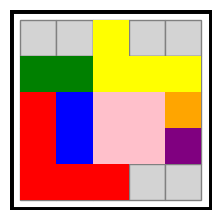

To a state incorporating the following block position(s):


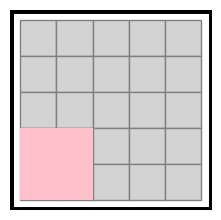

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.....
:-)) *SUCCESS* ((-:

Path length = 49
Goal state is:


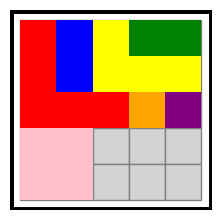

The action path to the solution is:
('green', 'up')
('blue', 'up')
('purple', 'down')
('orange', 'down')
('purple', 'left')
('orange', 'down')
('pink', 'right')
('red', 'up')
('purple', 'left')
('orange', 'left')
('purple', 'left')
('orange', 'left')
('pink', 'down')
('yellow', 'down')
('green', 'right')
('green', 'right')
('green', 'right')
('yellow', 'up')
('pink', 'up')
('orange', 'right')
('orange', 'right')
('purple', 'right')
('purple', 'right')
('red', 'down')
('blue', 'down')
('yellow', 'left')
('yellow', 'left')
('pink', 'left')
('orange', 'up')
('orange', 'up')
('orange', 'up')
('orange', 'left')
('purple', 'right')
('purple', 'up')
('purple', 'up')
('purple', 'up')
('pink', 'right')
('pink', 'down')
('orange', 'down')
('yellow', 'right')
('purple', 'down')
('yellow', 'right')
('blue', 'up')
('red', 'up')
('blue', 'up')
('red', 'up')
('pink', 'left')
('pink', 'left')
('pink', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    25871  (includes start)
Nodes disca

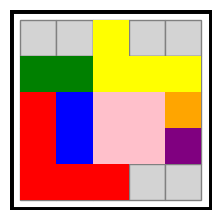

To a state incorporating the following block position(s):


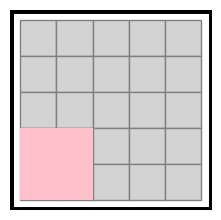

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.....
:-)) *SUCCESS* ((-:

Path length = 49
Goal state is:


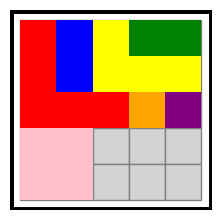

The action path to the solution is:
('green', 'up')
('blue', 'up')
('purple', 'down')
('orange', 'down')
('purple', 'left')
('orange', 'down')
('pink', 'right')
('red', 'up')
('purple', 'left')
('orange', 'left')
('purple', 'left')
('orange', 'left')
('pink', 'down')
('yellow', 'down')
('green', 'right')
('green', 'right')
('green', 'right')
('yellow', 'up')
('pink', 'up')
('orange', 'right')
('orange', 'right')
('purple', 'right')
('purple', 'right')
('red', 'down')
('blue', 'down')
('yellow', 'left')
('yellow', 'left')
('pink', 'left')
('orange', 'up')
('orange', 'up')
('orange', 'up')
('orange', 'left')
('purple', 'right')
('purple', 'up')
('purple', 'up')
('purple', 'up')
('pink', 'right')
('pink', 'down')
('orange', 'down')
('yellow', 'right')
('purple', 'down')
('yellow', 'right')
('blue', 'up')
('red', 'up')
('blue', 'up')
('red', 'up')
('pink', 'left')
('pink', 'left')
('pink', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    25871  (includes start)
Nodes disca

In [19]:
#Hard puzzle

hard = [[0,0,4,0,0],
        [3,3,4,4,4],
        [1,2,7,7,5],
        [1,2,7,7,6],
        [1,1,1,0,0]]

hard_goal    = [[0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],
                [7,7,0,0,0],
                [7,7,0,0,0]]

hard_puzzle =  SlidingBlocksPuzzle(hard, hard_goal)

hard_search_BF = search( hard_puzzle, 'BF/FIFO', 100000, loop_check=True, randomise=False, show_state_path=False, return_info=True)
hard_search_DF = search( hard_puzzle, 'BF/FIFO', 100000, loop_check=True, randomise=False, show_state_path=False, return_info=True)
##hard_search_best_first = search( hard_puzzle, 'BF/FIFO', 100000, loop_check=True, randomise=False, show_state_path=False, return_info=True)
##hard_search_A_star = search( hard_puzzle, 'BF/FIFO', 100000, loop_check=True, randomise=False, show_state_path=False, return_info=True)


In [ ]:
#Youtube puzzle
'''
YouTubeVideo = [[5,7,8,0],
        [6,7,9,0],
        [4,10,10,3],
        [4,10,10,3],
        [1,1,2,2]]

YouTubeVideoGoal    = [[0,0,0,0],
                [0,0,0,0],
                [0,0,0,0],
                [0,10,10,0],
                [0,10,10,0]]

yt_puzzle =  SlidingBlocksPuzzle(YouTubeVideo, YouTubeVideoGoal )'''

#yt_search = search( yt_puzzle, 'BF/FIFO', 100000000, loop_check=True, randomise=False, show_state_path=True, return_info=True)

<a href="https://colab.research.google.com/github/mario-manini/AICwk/blob/main/SlidingBlocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


























































# ---------------------------------------------------

## **Sliding Blocks Report**
# Sliding Blocks Puzzles

Mario Manini & Jonghyun Kim

In this exercise we shall investigate a family of _**sliding blocks**_ puzzles, which can be regarded as a generalisation of puzzles such as **8-Puzzle** and **15-Puzzle**. We now consider puzzles in which the sliding elements are not only single squares but can also be any shape formed by joining several squares
(sometimes called _polyominoes_).

You can see a wide variety of examples of sliding block puzzles at:
* [Nick Baxter's Sliding Block Puzzle Page](https://www.johnrausch.com/SlidingBlockPuzzles/)

### Exercise Overview

This exercise will provide you with classes that can represent sliding blocks puzzles in a general way and include methods that interface the representation with Brandon's `bbSearch` module.

It will illustrate the use of `bbSearch` for this kind of problem with a few examples. It will then consider possible heuristics. You will see that event quite simple heuristics can give very significant performance improvements, compared to exhaustive un-informed search.

Having seen these examples you will be ready to do some investigation and experimentation on your own, including:

* Creating your own puzzles of different levels of difficulty.
* Testing different search algorithms and parameters.
* Devising heuristics to guide the search.
* Carrying out systemmatic comparisons between different search algorithms on a variety of different problems and using different heuristics.

### Setup

As usual we will be using `bbSearch.py`, which is loaded by the following cell. By now, if you have been doing the search exercises you should be familiar with how this software works. However, if you need some revision of how to run the search algorithm and the various options available, you should go back to **Search Exercise 2** which explains the basic usuage. And you may also want to go through some of the examples in exercises **3-6**.

### State Representation:
We will represent a given state of a sliding blocks puzzle by an array stored as a list of lists --- a list of rows, with each row being a list of individual cells. (This representation has been chosen for clarity rather than efficiency.) Each cell will contain an integer, where `0` will represent an empty cell and positive integers will represent the colour of a _polyomino_ section contained in that cell.

So a state might be represented as follows:
```python
  [ [1,3,0,0,0,0,6],
    [1,3,4,4,0,0,0],
    [3,3,4,0,0,0,0],
    [0,4,4,2,0,0,0],
    [0,0,2,2,5,5,5] ]
```
You will see a colouful graphic representation of this puzzle state below, once we have defined a class of storing, manipulating and displaying puzzle states.


## The `BlockState` Class

Although the list-of-lists array format is a concise way to specify and store puzzle states, it will be convenient to define a class that can encapsulate the various methods that we will want to use to access, manipulate, and display the states of a Sliding Blocks puzzle.

Take a look at the following code cell that defines `BlockState`. You don't need to worry much about `figure` that creates a graphical display. However, it will be useful to look at: `possible_moves` and `next_state`, which will be used by the search algorithm, and it may also be interesting to look at `free_cell` and `free_block`, that are used in calculating `possible_moves`.

Note the global variable `COLORS`, which implicitly specifies a mapping from integers to colours that is used to specify board states and goals. Integer `n` corresponds to the `n`th colour name in the list.

In [ ]:
def red_right_heuristic(state):
    for row in state.blockstate:
      for i, col in enumerate(row):
          if col == 1:
            return 6-i



In [ ]:
def manhattan_heuristic(state):
    print(test.goal)

    totaldistance = 0
    found = []

    statecopy = deepcopy(state)

    for row_index, row in enumerate(test.goal.blockstate):
        for col_index, cell in enumerate(row):
            if (cell != 0):  
                #If a non zero is found in the goal state
                # Locate the cell in state and find the closest one
                for current_row_index, current_row in enumerate(statecopy.blockstate):
                    for current_col_index, currentcell in enumerate(current_row):
                        distance = 0
                        if currentcell == cell:
                            distance = abs(current_row_index - row_index) + abs(current_col_index - col_index)
                            totaldistance += distance
                            print(f"added {distance}")
                            statecopy.blockstate[current_row_index][current_col_index] = 0

                            print("\n")
                            for row in statecopy.blockstate:
                                print(row)
                                
    return totaldistance


    #totaldistance = totaldistance + abs()
    #get the distance using goal and state and add it to total distance



    #compare this to state.blockstate[row][cell]
    #add the number to found
    #Look at the state and look at the goal and 


In [ ]:
state =[[1,1,1,1,1,1,7],
        [1,8,0,1,6,0,7],
        [1,1,0,1,0,7,7],
        [5,5,0,1,0,7,7],
        [5,5,0,2,0,7,7],
        [5,5,0,3,7,7,7],
        [4,4,4,3,7,7,7]]

bs = BlockState(state) #EXAMPLE STATE


medium =[[1,1,1,1,1,1,7],
        [1,8,0,1,6,0,7],
        [1,1,0,1,0,7,7],
        [5,5,0,1,0,7,7],
        [5,5,0,2,0,7,7],
        [5,5,0,3,7,7,7],
        [4,4,4,3,7,7,7]]

medium_goal = [[0,0,0,0,0,0,0],
                [0,6,0,0,0,8,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0]]
test = SlidingBlocksPuzzle(medium, medium_goal)
print(manhattan_heuristic(bs))

[[0, 0, 0, 0, 0, 0, 0], [0, 6, 0, 0, 0, 8, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
added 3


[1, 1, 1, 1, 1, 1, 7]
[1, 8, 0, 1, 0, 0, 7]
[1, 1, 0, 1, 0, 7, 7]
[5, 5, 0, 1, 0, 7, 7]
[5, 5, 0, 2, 0, 7, 7]
[5, 5, 0, 3, 7, 7, 7]
[4, 4, 4, 3, 7, 7, 7]
added 4


[1, 1, 1, 1, 1, 1, 7]
[1, 0, 0, 1, 0, 0, 7]
[1, 1, 0, 1, 0, 7, 7]
[5, 5, 0, 1, 0, 7, 7]
[5, 5, 0, 2, 0, 7, 7]
[5, 5, 0, 3, 7, 7, 7]
[4, 4, 4, 3, 7, 7, 7]
7


In [50]:

bs = [[0,0,4,0,0],
        [3,3,4,4,4],
        [1,2,7,7,5],
        [1,2,7,7,6],
        [1,1,1,0,0]]

ts = BlockState(bs) #EXAMPLE STATE


hard = [[0,0,4,0,0],
        [3,3,4,4,4],
        [1,2,7,7,5],
        [1,2,7,7,6],
        [1,1,1,0,0]]

hard_goal    = [[0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],
                [7,7,0,0,0],
                [7,7,0,0,0]]

test = SlidingBlocksPuzzle(hard, hard_goal)
print("hi")
print(manhattan_heuristic(ts))





hi
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [7, 7, 0, 0, 0], [7, 7, 0, 0, 0]]
added 3


[0, 0, 4, 0, 0]
[3, 3, 4, 4, 4]
[1, 2, 0, 7, 5]
[1, 2, 7, 7, 6]
[1, 1, 1, 0, 0]
added 4


[0, 0, 4, 0, 0]
[3, 3, 4, 4, 4]
[1, 2, 0, 0, 5]
[1, 2, 7, 7, 6]
[1, 1, 1, 0, 0]
added 2


[0, 0, 4, 0, 0]
[3, 3, 4, 4, 4]
[1, 2, 0, 0, 5]
[1, 2, 0, 7, 6]
[1, 1, 1, 0, 0]
added 3


[0, 0, 4, 0, 0]
[3, 3, 4, 4, 4]
[1, 2, 0, 0, 5]
[1, 2, 0, 0, 6]
[1, 1, 1, 0, 0]
12


Solve the following sliding blocks problem.
Get from this initial state:


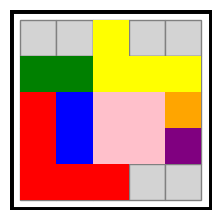

To a state incorporating the following block position(s):


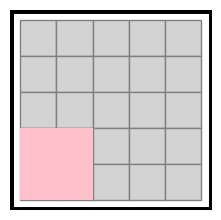

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=purple_heuristic
Max search nodes: 10000000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 119
Goal state is:


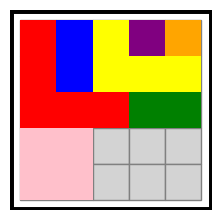

The action path to the solution is:
('purple', 'down')
('purple', 'left')
('green', 'up')
('blue', 'up')
('orange', 'down')
('orange', 'down')
('pink', 'right')
('red', 'up')
('purple', 'left')
('purple', 'left')
('purple', 'left')
('orange', 'left')
('orange', 'left')
('pink', 'down')
('yellow', 'down')
('green', 'right')
('green', 'right')
('blue', 'up')
('green', 'right')
('yellow', 'up')
('red', 'up')
('purple', 'up')
('pink', 'up')
('orange', 'right')
('orange', 'right')
('purple', 'down')
('red', 'down')
('purple', 'right')
('purple', 'right')
('purple', 'right')
('red', 'down')
('pink', 'left')
('pink', 'left')
('purple', 'up')
('purple', 'up')
('blue', 'left')
('yellow', 'left')
('purple', 'right')
('purple', 'up')
('green', 'left')
('purple', 'up')
('orange', 'up')
('orange', 'up')
('orange', 'up')
('pink', 'right')
('pink', 'right')
('pink', 'down')
('yellow', 'down')
('green', 'down')
('purple', 'left')
('purple', 'left')
('purple', 'left')
('orange', 'up')
('green', 'right'

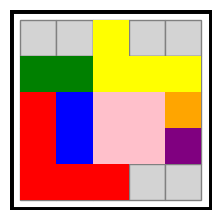

('purple', 'down')


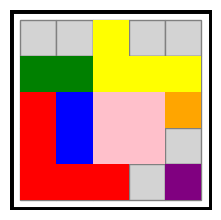

('purple', 'left')


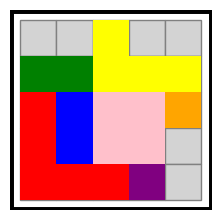

('green', 'up')


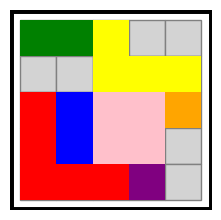

('blue', 'up')


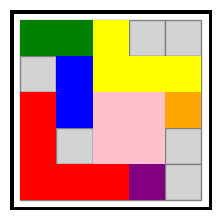

('orange', 'down')


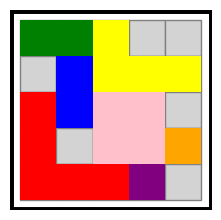

('orange', 'down')


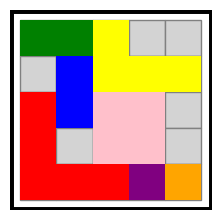

('pink', 'right')


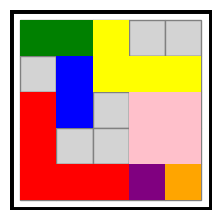

('red', 'up')


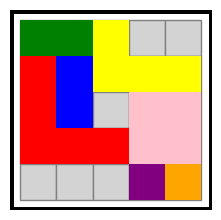

('purple', 'left')


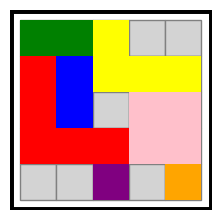

('purple', 'left')


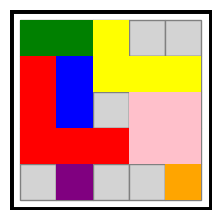

('purple', 'left')


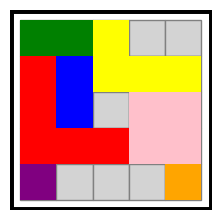

('orange', 'left')


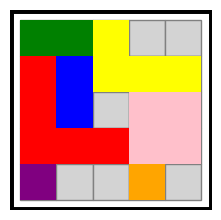

('orange', 'left')


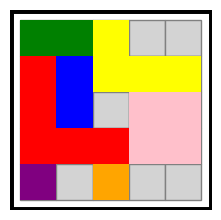

('pink', 'down')


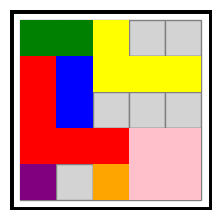

('yellow', 'down')


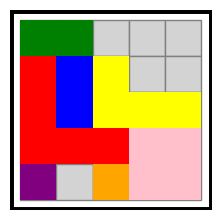

('green', 'right')


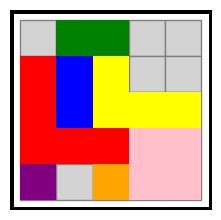

('green', 'right')


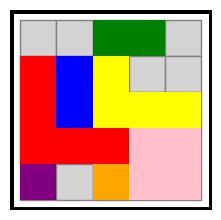

('blue', 'up')


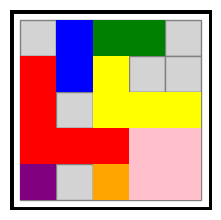

('green', 'right')


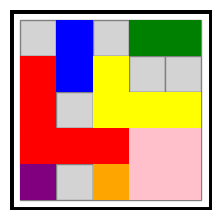

('yellow', 'up')


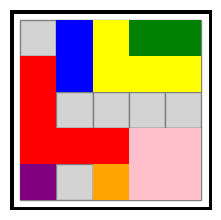

('red', 'up')


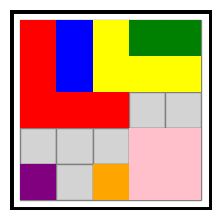

('purple', 'up')


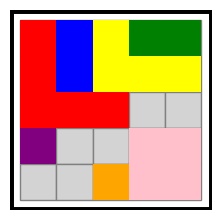

('pink', 'up')


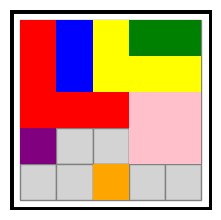

('orange', 'right')


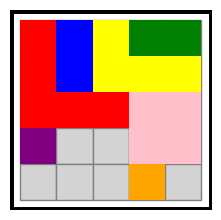

('orange', 'right')


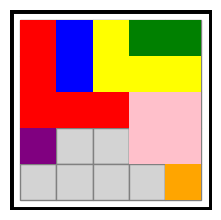

('purple', 'down')


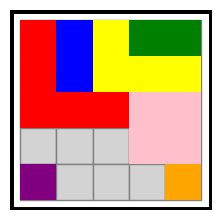

('red', 'down')


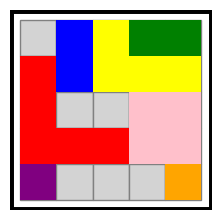

('purple', 'right')


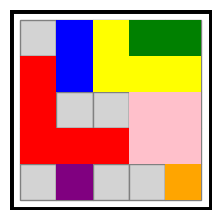

('purple', 'right')


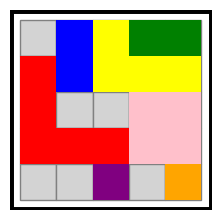

('purple', 'right')


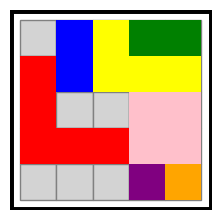

('red', 'down')


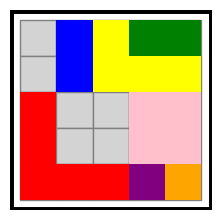

('pink', 'left')


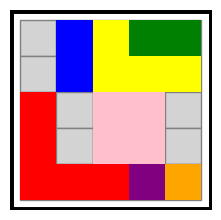

('pink', 'left')


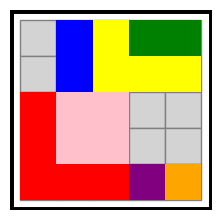

('purple', 'up')


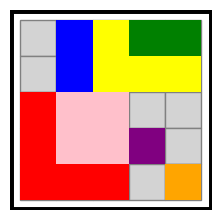

('purple', 'up')


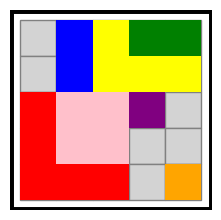

('blue', 'left')


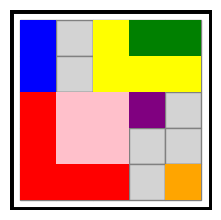

('yellow', 'left')


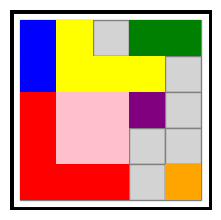

('purple', 'right')


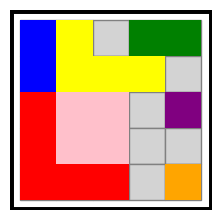

('purple', 'up')


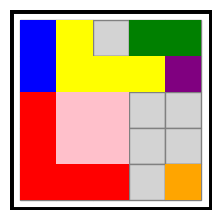

('green', 'left')


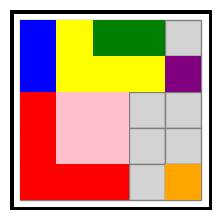

('purple', 'up')


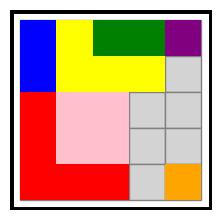

('orange', 'up')


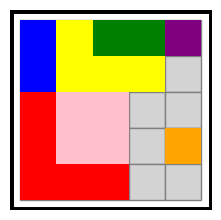

('orange', 'up')


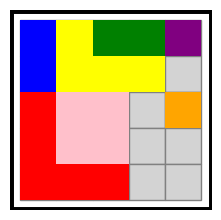

('orange', 'up')


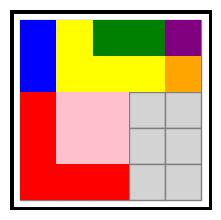

('pink', 'right')


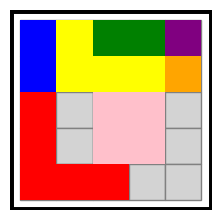

('pink', 'right')


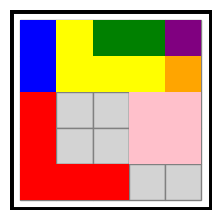

('pink', 'down')


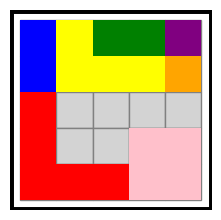

('yellow', 'down')


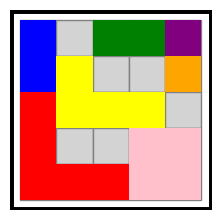

('green', 'down')


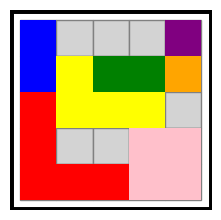

('purple', 'left')


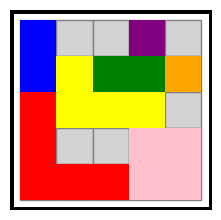

('purple', 'left')


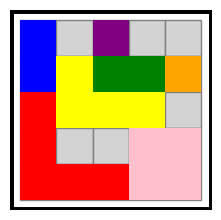

('purple', 'left')


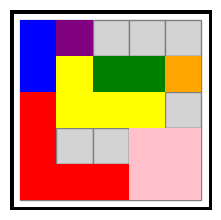

('orange', 'up')


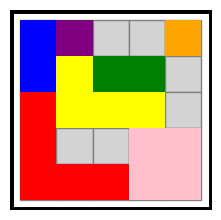

('green', 'right')


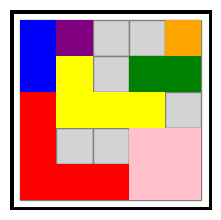

('yellow', 'right')


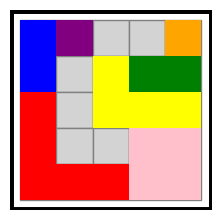

('purple', 'right')


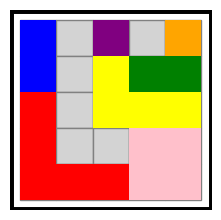

('blue', 'right')


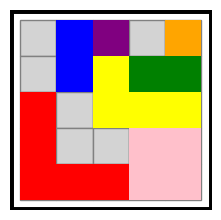

('blue', 'down')


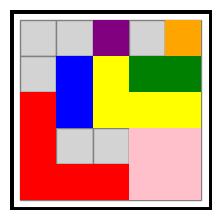

('purple', 'left')


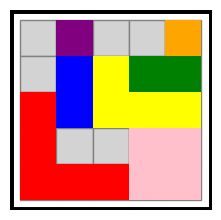

('purple', 'left')


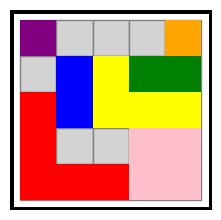

('blue', 'down')


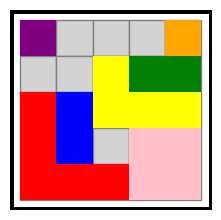

('orange', 'left')


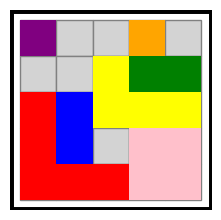

('orange', 'left')


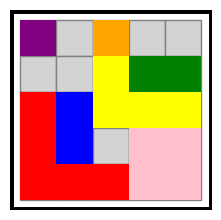

('green', 'up')


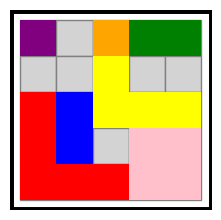

('orange', 'left')


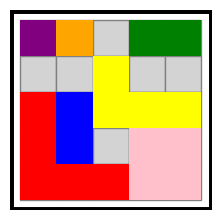

('yellow', 'up')


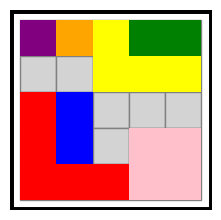

('blue', 'right')


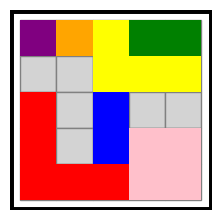

('orange', 'down')


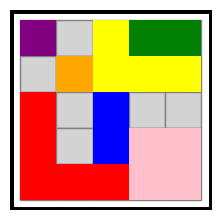

('orange', 'down')


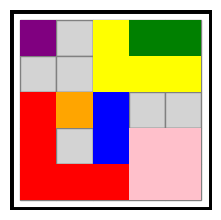

('orange', 'down')


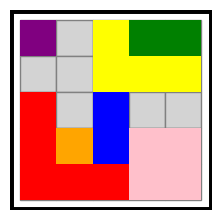

('purple', 'right')


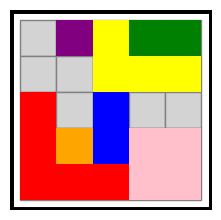

('purple', 'down')


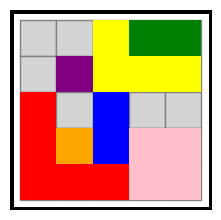

('purple', 'down')


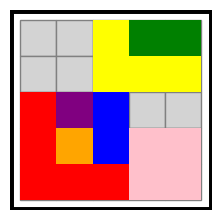

('yellow', 'left')


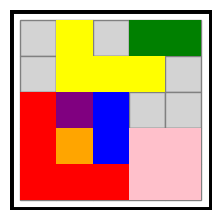

('yellow', 'left')


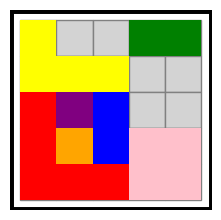

('green', 'down')


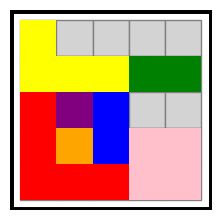

('green', 'down')


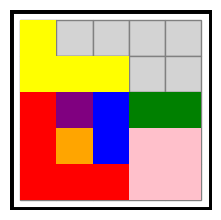

('yellow', 'right')


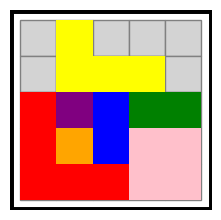

('yellow', 'right')


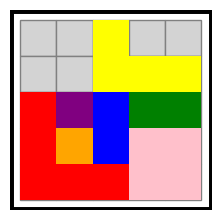

('purple', 'up')


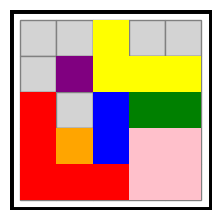

('purple', 'left')


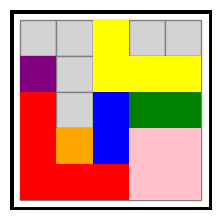

('purple', 'up')


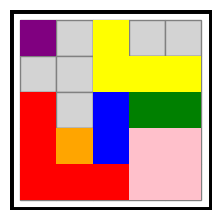

('orange', 'up')


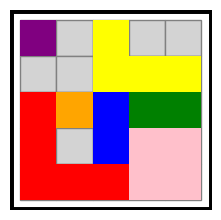

('orange', 'up')


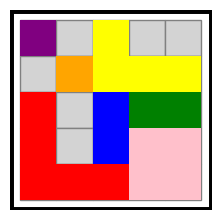

('blue', 'left')


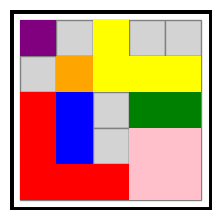

('green', 'left')


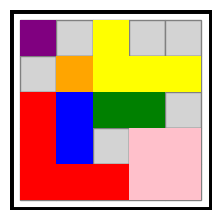

('orange', 'up')


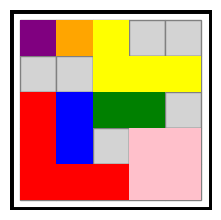

('blue', 'up')


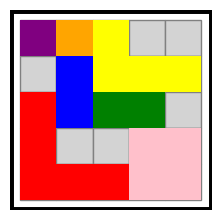

('purple', 'down')


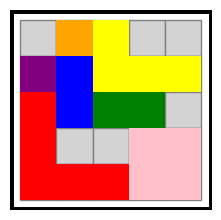

('orange', 'left')


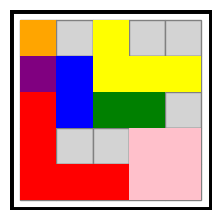

('blue', 'up')


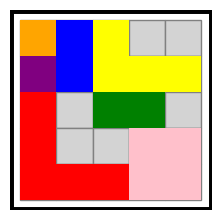

('green', 'left')


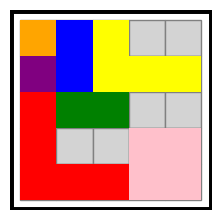

('green', 'down')


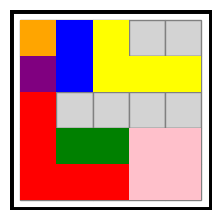

('blue', 'down')


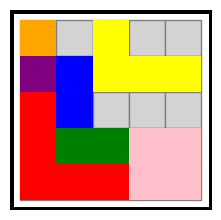

('orange', 'right')


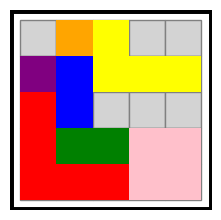

('purple', 'up')


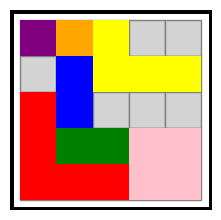

('yellow', 'down')


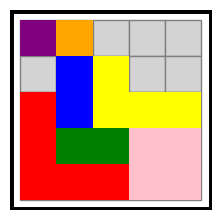

('orange', 'right')


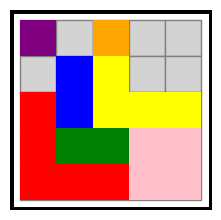

('orange', 'right')


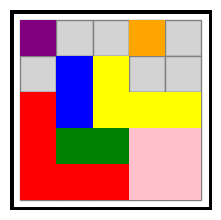

('purple', 'right')


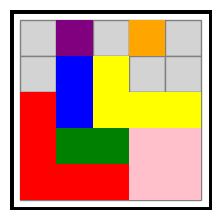

('purple', 'right')


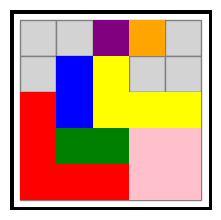

('blue', 'up')


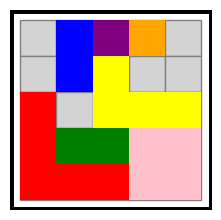

('blue', 'left')


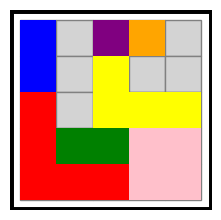

('purple', 'left')


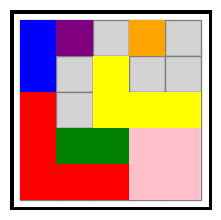

('yellow', 'left')


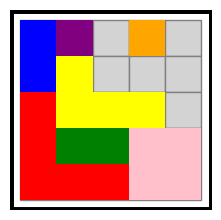

('orange', 'right')


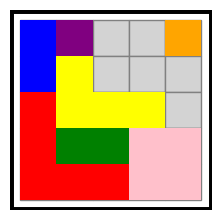

('purple', 'right')


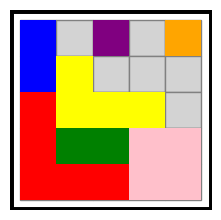

('yellow', 'up')


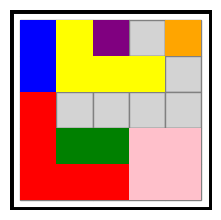

('green', 'up')


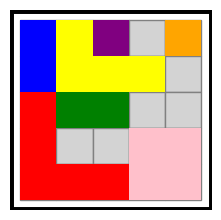

('green', 'right')


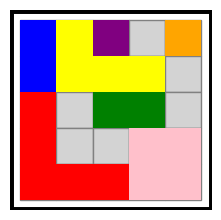

('green', 'right')


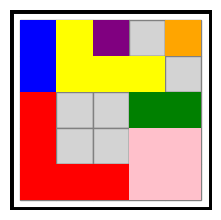

('purple', 'right')


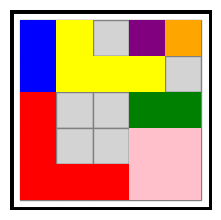

('yellow', 'right')


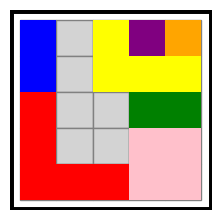

('blue', 'right')


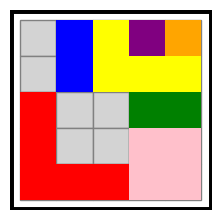

('red', 'up')


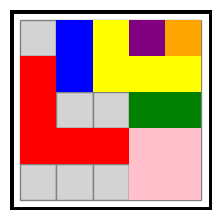

('red', 'up')


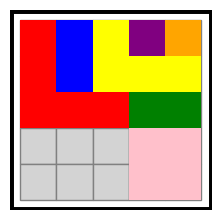

('pink', 'left')


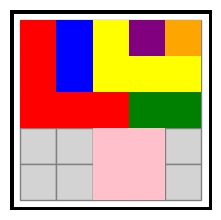

('pink', 'left')


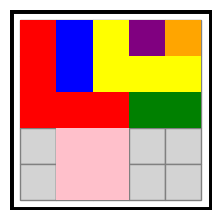

('pink', 'left')


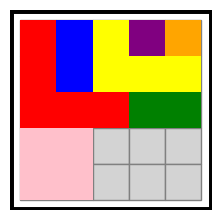


SEARCH SPACE STATS:
Total nodes generated          =    23547  (includes start)
Nodes discarded by loop_check  =    17177  (6370 distinct states added to queue)
Nodes tested (by goal_test)    =     4900  (4899 expanded + 1 goal)
Nodes left in queue            =     1470

Time taken = 7.6759 seconds



In [22]:
def purple_heuristic(state):
      for r, row in enumerate(state.blockstate):
        for c, col in enumerate(row):
          if col == 6:
            return r+c

def red_and_purple_heuristic(state):
  return (red_right_heuristic(state) + purple_heuristic(state))

clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = purple_heuristic,
                     loop_check=True, randomise=False, show_state_path=True, return_info=True)
                     

## Collecting and Tabulating Results

As we saw in earlier exercercises, when researching search problems and algorithms, it can be informative to collect results of a series of tests in the form of a table. This is illustrated in the next code cell.

In [ ]:

TEST_RESULTS =[easy_search]

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

print("\n                **TESTS SUMMARY**\n")

print("Test    #max   Result   #gen     #inQ    Time s")
for i, test in enumerate(TEST_RESULTS):
    max  = test['args']['max_nodes']
    tc  = test['result']['termination_condition']
    stc = short_tc[tc]

    ng  = test['search_stats']['nodes_generated']
    nq  = test['search_stats']['nodes_left_in_queue']
    time = round( test['search_stats']['time_taken'], 2 )
    print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")


                **TESTS SUMMARY**

Test    #max   Result   #gen     #inQ    Time s
  0:    10000    Y      2838      144     0.67 
